## Python - 计算可降水量

- 从比湿计算可降水量

- 转换经度从-180~180 转换为0~360，为了后续与模式的数据一致

- 从numpy和xarray的角度分别计算垂直积分



导入工具库


In [180]:
import xarray as xr

import numpy  as np

In [181]:
sph = xr.open_dataset("I://sph.monthly.2010_2019.nc").q
sph

<xarray.DataArray 'q' (time: 120, level: 37, latitude: 181, longitude: 360)> Size: 2GB
[289310400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 960B 2010-01-01 2010-02-01 ... 1900-01-01
  * longitude  (longitude) float32 1kB -180.0 -179.0 -178.0 ... 178.0 179.0
  * latitude   (latitude) float32 724B 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
Attributes:
    standard_name:  specific_humidity
    long_name:      Specific humidity
    units:          kg kg**-1

读取比湿变量，可以发现其经度排序为-180~180，纬度排序为90~-90

绘制一下空间分布图，如果设置中心经度为180时，会在中心经度显示一条白线；设置中心经度为0时，则正常显示

此时去掉白线的解决办法主要有两个

- 1、对于经度数据加上add_cyclic_point,详见（https://blog.csdn.net/weixin_44237337/article/details/118883720）
- 2、调整数据经度范围为 0~360 



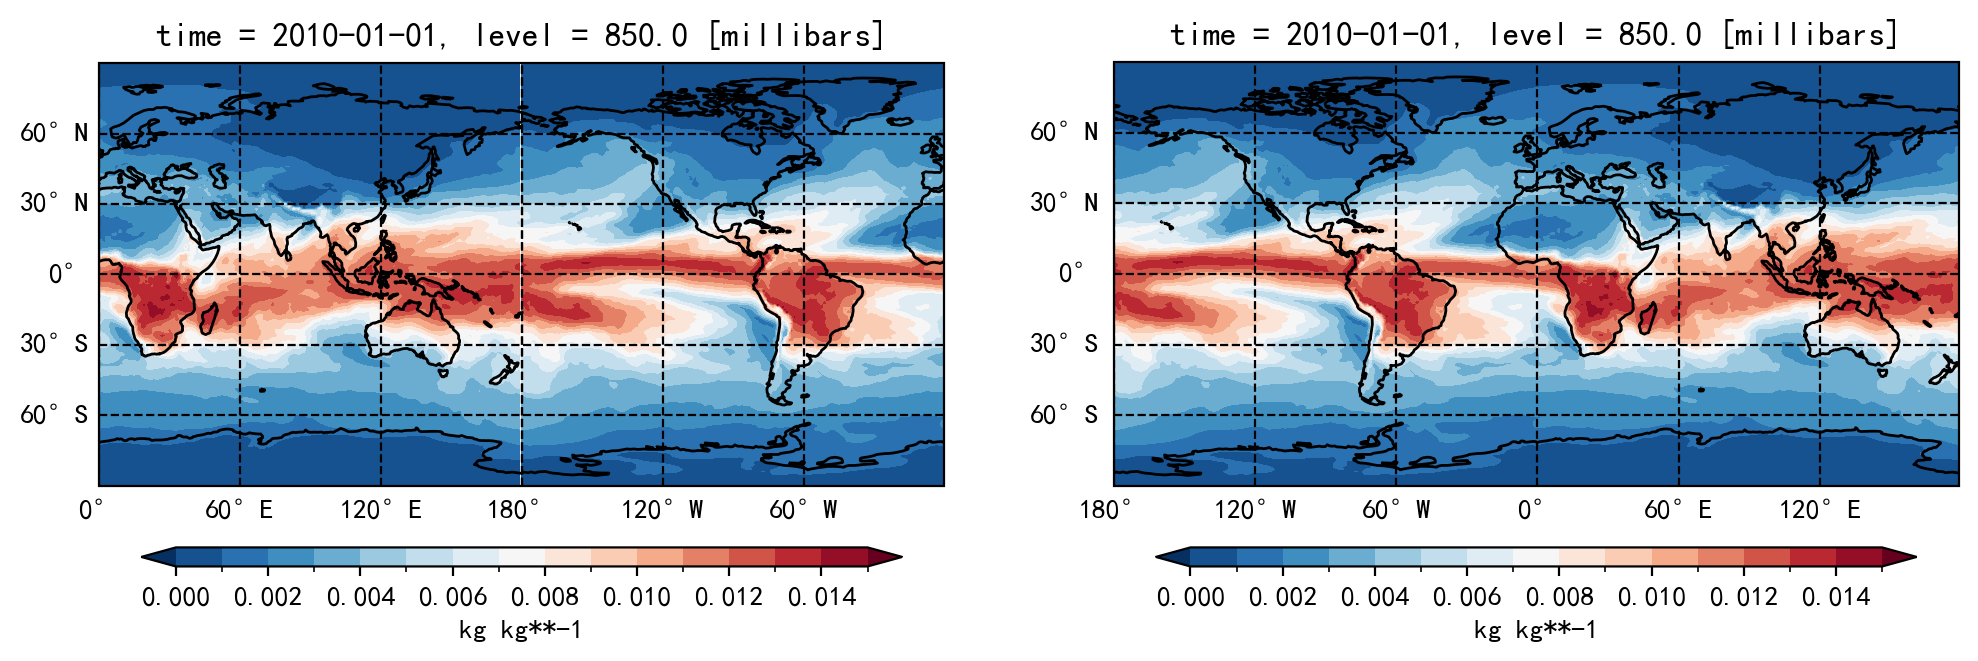

In [182]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig= plt.figure( dpi=200, figsize=(12, 4))

# 第一个图，中心经度为180
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(180))
contour1 = sph.sel(level=850)[0].plot.contourf(ax=ax1, levels=16, cmap='RdBu_r', extend='both', add_colorbar=False,
                                               transform=ccrs.PlateCarree())
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True, linestyle='--',color='k')  # 添加经纬度网格并显示标签
gl1.right_labels = False  # 关闭右侧标签
gl1.top_labels = False    # 关闭顶部标签
cbar1 = fig.colorbar(contour1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.9,aspect=40)
cbar1.set_label('kg kg**-1') 

# 第二个图，中心经度为0
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree(0))
contour2 = sph.sel(level=850)[0].plot.contourf(ax=ax2, levels=16, cmap='RdBu_r', extend='both', add_colorbar=False,
                                               transform=ccrs.PlateCarree())
ax2.coastlines()
gl2 = ax2.gridlines(draw_labels=True, linestyle='--',color='k')  # 添加经纬度网格并显示标签
gl2.right_labels = False  # 关闭右侧标签
gl2.top_labels = False    # 关闭顶部标签
cbar2 = fig.colorbar(contour2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.9,aspect=40)
cbar2.set_label('kg kg**-1')  

plt.show()

下面将其转换，经度排序转换为0~360,并按照升序排列纬度

In [183]:
def convert_lon(ds,lons='longitude',lats='latitude'):
    ds = ds.sortby(lats)
    lon_name = lons  #你的nc文件中经度的命名
    ds['longitude_adjusted'] = xr.where(ds[lon_name] < 0, ds[lon_name]%360,\
                        ds[lon_name])
    ds = (
    ds
    .swap_dims({lon_name: 'longitude_adjusted'})
    .sel(**{'longitude_adjusted': sorted(ds.longitude_adjusted)})
    .drop_vars(lon_name))
    ds = ds.rename({'longitude_adjusted': lon_name})

    return ds

sph_convert = convert_lon(sph)
sph_convert

<xarray.DataArray 'q' (time: 120, level: 37, latitude: 181, longitude: 360)> Size: 2GB
[289310400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 960B 2010-01-01 2010-02-01 ... 1900-01-01
  * latitude   (latitude) float32 724B -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes:
    standard_name:  specific_humidity
    long_name:      Specific humidity
    units:          kg kg**-1

验证一下经度修改后的空间分布图,中心经度为180的白线消失了，但是出现在了中心经度为0的地方;
- 道理是一致的

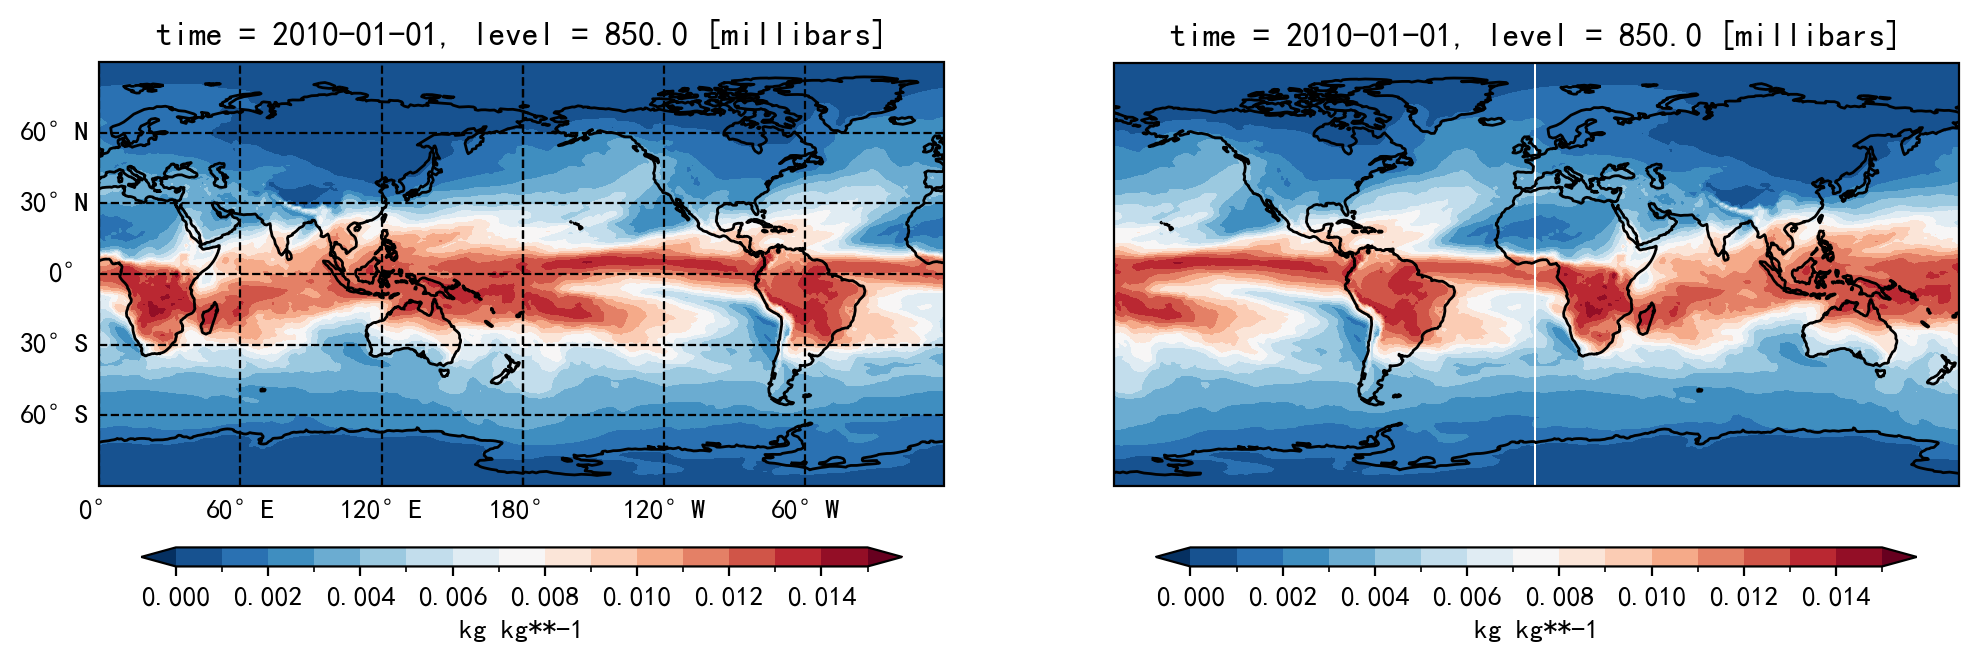

In [184]:
fig= plt.figure( dpi=200, figsize=(12, 4))

# 第一个图，中心经度为180
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(180))
contour1 = sph_convert.sel(level=850)[0].plot.contourf(ax=ax1, levels=16, cmap='RdBu_r', extend='both', add_colorbar=False,
                                               transform=ccrs.PlateCarree())
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True, linestyle='--',color='k')  # 添加经纬度网格并显示标签
gl1.right_labels = False  # 关闭右侧标签
gl1.top_labels = False    # 关闭顶部标签
cbar1 = fig.colorbar(contour1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.9,aspect=40)
cbar1.set_label('kg kg**-1') 

# 第二个图，中心经度为0
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree(0))
contour2 = sph_convert.sel(level=850)[0].plot.contourf(ax=ax2, levels=16, cmap='RdBu_r', extend='both', add_colorbar=False,
                                               transform=ccrs.PlateCarree())
ax2.coastlines()
# gl2 = ax2.gridlines(draw_labels=True, linestyle='--',color='k')  # 添加经纬度网格并显示标签
# gl2.right_labels = False  # 关闭右侧标签
# gl2.top_labels = False    # 关闭顶部标签
cbar2 = fig.colorbar(contour2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.9,aspect=40)
cbar2.set_label('kg kg**-1')  

plt.show()

为了方便计算，这里提取高度层从100-1000hpa,并将数据插值到2x2分辨率

In [185]:
sph_interp = sph_convert.sel(level=slice(100,1000)).interp(longitude=np.arange(0,360,2),latitude=np.arange(-40,42,2))
sph_interp 

<xarray.DataArray 'q' (time: 120, level: 27, latitude: 41, longitude: 180)> Size: 191MB
array([[[[2.38364690e-06, 2.38364690e-06, 2.38364690e-06, ...,
          2.38364690e-06, 2.38364690e-06, 2.38364690e-06],
         [2.38364690e-06, 2.38364690e-06, 2.38364690e-06, ...,
          2.38364690e-06, 2.38364690e-06, 2.38364690e-06],
         [2.76885945e-06, 2.76885945e-06, 2.76885945e-06, ...,
          2.76885945e-06, 2.76885945e-06, 2.76885945e-06],
         ...,
         [2.38364690e-06, 2.38364690e-06, 2.38364690e-06, ...,
          2.38364690e-06, 2.38364690e-06, 2.38364690e-06],
         [2.76885945e-06, 2.76885945e-06, 2.76885945e-06, ...,
          2.76885945e-06, 2.76885945e-06, 2.76885945e-06],
         [2.76885945e-06, 2.76885945e-06, 2.76885945e-06, ...,
          2.76885945e-06, 2.76885945e-06, 2.76885945e-06]],

        [[3.15407199e-06, 3.15407199e-06, 3.15407199e-06, ...,
          3.15407199e-06, 3.15407199e-06, 3.15407199e-06],
         [3.15407199e-06, 3.15407199e-06, 3.15407199e-06, ...,
          3.15407199e-06, 3.15407199e-06, 3.15407199e-06],
         [3.53928454e-06, 3.53928454e-06, 3.53928454e-06, ...,
          3.53928454e-06, 3.53928454e-06, 3.53928454e-06],
...
         [1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02],
         [1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02],
         [1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02]],

        [[1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02],
         [1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02],
         [1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02],
         ...,
         [1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02],
         [1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02],
         [1.26223318e-02, 1.26223318e-02, 1.26223318e-02, ...,
          1.26223318e-02, 1.26223318e-02, 1.26223318e-02]]]])
Coordinates:
  * time       (time) datetime64[ns] 960B 2010-01-01 2010-02-01 ... 1900-01-01
  * level      (level) float64 216B 100.0 125.0 150.0 ... 950.0 975.0 1e+03
  * longitude  (longitude) int32 720B 0 2 4 6 8 10 ... 348 350 352 354 356 358
  * latitude   (latitude) int32 164B -40 -38 -36 -34 -32 -30 ... 32 34 36 38 40
Attributes:
    standard_name:  specific_humidity
    long_name:      Specific humidity
    units:          kg kg**-1

看一下插值后的结果

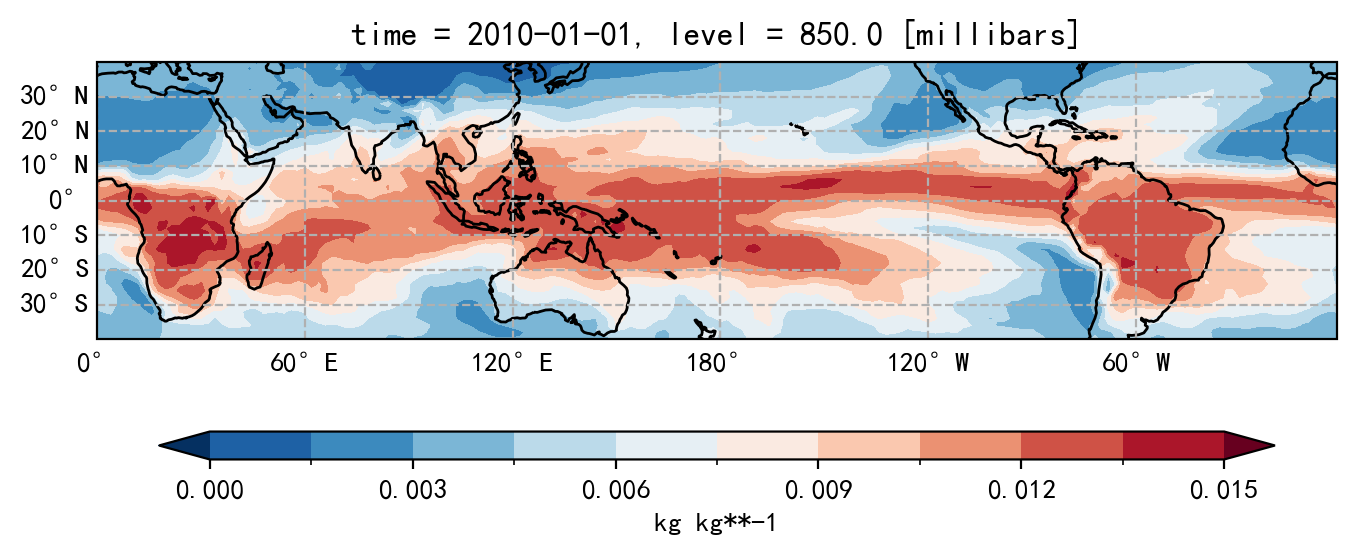

In [186]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(180)}, dpi=200,figsize=(8, 6))
contour = sph_interp.sel(level=850)[0].plot.contourf(ax=ax, levels=11, cmap='RdBu_r', extend='both', add_colorbar=False,
                                              transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linestyle='--')  # 添加经纬度网格并显示标签
gl.right_labels = False  # 关闭右侧标签
gl.top_labels = False    # 关闭顶部标签

# 添加横轴方向的colorbar
cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.1, shrink=0.9,aspect=40)
cbar.set_label('kg kg**-1')  

plt.show()

计算可降水量，定义为垂直积分的比湿

- 转换气压层单位为pa，并将其从高到低进行排序
- 使用梯形积分计算整层水汽积分

$$\text{Column-integrated specific humidity}=\frac{1}{g}\int_{p_t}^{p_s}q(p) dp$$


- q 是比湿（单位为 kg kg$^{⁻¹}$
- $p_s$是地表气压
- $p_t$是顶层气压


$$\frac{1}{g}\times(kg kg^{-1}\times Pa)=\frac{kg}{m^2}$$

1、xarray的积分计算

In [187]:
def xarray_intergrated(sph):

    pressure = (sph.level * 100) # 转换为 Pa
    print(pressure)
    # 定义重力加速度常数
    g = 9.81  # m/s²

    # 计算dp（差分），并取绝对值
    dp = pressure.diff(dim='level')
   
    # 计算垂直积分 (Column-integrated specific humidity)
    column_integrated_sph = (sph * dp).sum(dim='level') / g

    # 输出结果，单位为 kg/m²
    print(column_integrated_sph.min(), column_integrated_sph.max())
    return column_integrated_sph
sph_trap = xarray_intergrated(sph_interp)
sph_trap

<xarray.DataArray 'level' (level: 27)> Size: 216B
array([ 10000.,  12500.,  15000.,  17500.,  20000.,  22500.,  25000.,
        30000.,  35000.,  40000.,  45000.,  50000.,  55000.,  60000.,
        65000.,  70000.,  75000.,  77500.,  80000.,  82500.,  85000.,
        87500.,  90000.,  92500.,  95000.,  97500., 100000.])
Coordinates:
  * level    (level) float64 216B 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03
<xarray.DataArray ()> Size: 8B
array(2.25372541) <xarray.DataArray ()> Size: 8B
array(115.80120938)


<xarray.DataArray (time: 120, latitude: 41, longitude: 180)> Size: 7MB
array([[[ 19.45959123,  19.36269908,  19.18432722, ...,  19.72631459,
          19.61155581,  19.57061962],
        [ 19.28740397,  19.34375259,  19.23046634, ...,  19.77049034,
          19.5443105 ,  19.30576145],
        [ 19.70353954,  20.0130643 ,  20.20331453, ...,  20.39061971,
          20.35361025,  20.09346417],
        ...,
        [ 16.56077848,  16.47085628,  16.06699176, ...,  16.91467532,
          16.26666615,  16.01653323],
        [ 14.71914052,  15.62621593,  16.17998351, ...,  15.95939926,
          15.98786808,  14.62607694],
        [ 14.73258959,  15.37686836,  15.57222335, ...,  15.33671752,
          15.30343845,  14.95307566]],

       [[ 20.88538812,  20.91022471,  20.88371926, ...,  22.32757912,
          21.73925629,  21.27010982],
        [ 20.83600945,  20.92220125,  20.75718027, ...,  21.55519067,
          20.99720185,  20.80420291],
        [ 20.91621298,  20.90541446,  20.86565628, ...,  21.31850681,
          21.06160028,  20.87095737],
...
        [115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938],
        [115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938],
        [115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938]],

       [[115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938],
        [115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938],
        [115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938],
        ...,
        [115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938],
        [115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938],
        [115.80120938, 115.80120938, 115.80120938, ..., 115.80120938,
         115.80120938, 115.80120938]]])
Coordinates:
  * time       (time) datetime64[ns] 960B 2010-01-01 2010-02-01 ... 1900-01-01
  * longitude  (longitude) int32 720B 0 2 4 6 8 10 ... 348 350 352 354 356 358
  * latitude   (latitude) int32 164B -40 -38 -36 -34 -32 -30 ... 32 34 36 38 40

2、numpy的积分计算

2.1243886248371533 115.80120938274239


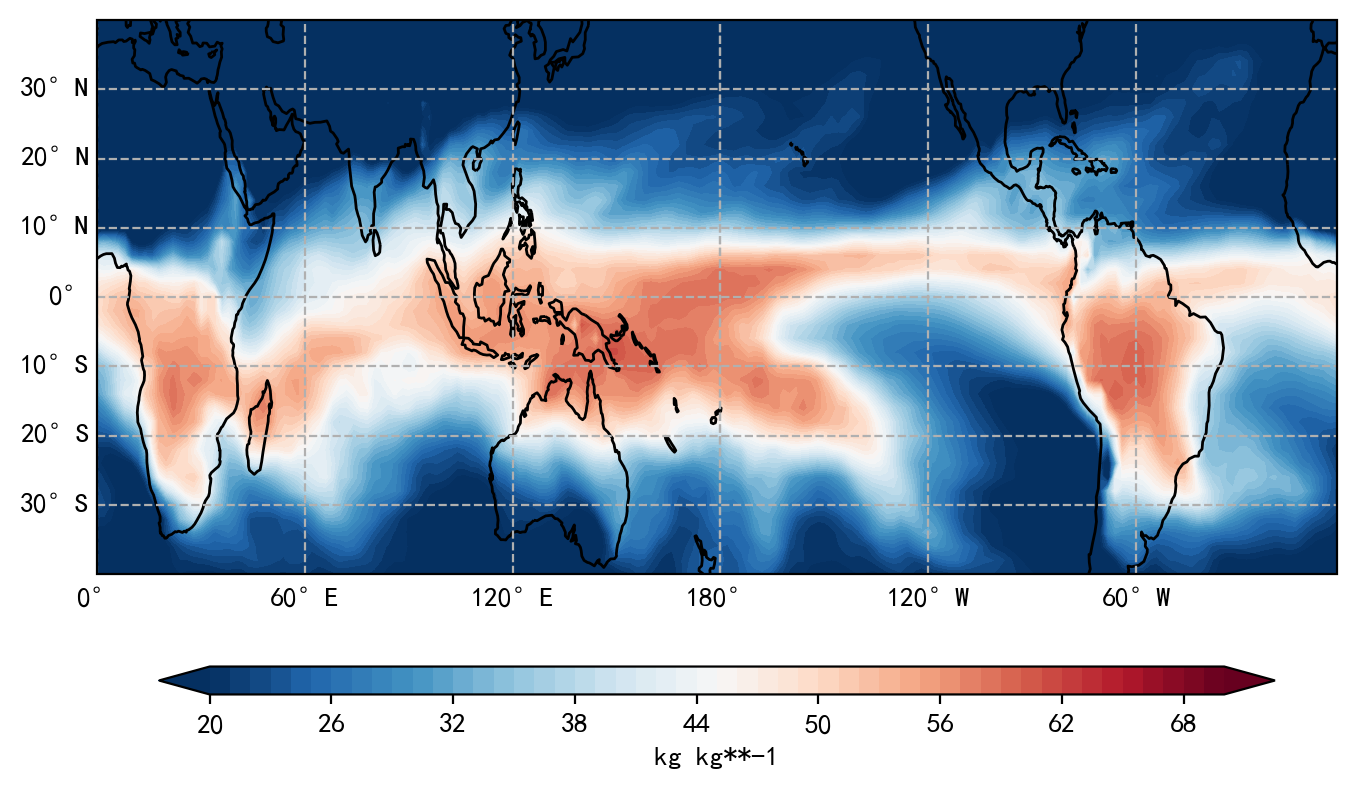

In [197]:
def numpy_intergrated(sph_interp):
    
    pressure_levels = sph_interp.level * 100  # 将 millibars 转换为 Pa

    # 重力加速度
    g = 9.81  # m/s²

    # 使用梯形积分法计算整层水汽积分
    sph_trap = np.trapz(sph_interp, pressure_levels, axis=1) / g
    print(sph_trap.min(),sph_trap.max())
    return sph_trap

sph_trap_numpy = numpy_intergrated(sph_interp)    


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(180)}, dpi=200,figsize=(8, 6))

contour = ax.contourf(sph_trap.longitude,sph_trap.latitude,sph_trap_numpy[0], 
                      levels=np.linspace(20,70,51), 
                      
                      cmap='RdBu_r', extend='both', 
                                              transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linestyle='--')  # 添加经纬度网格并显示标签
gl.right_labels = False  # 关闭右侧标签
gl.top_labels = False    # 关闭顶部标签
ax.set_aspect(2)
# 添加横轴方向的colorbar
cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.1, shrink=0.9,aspect=40)
cbar.set_label('kg kg**-1')  

plt.show()

看一下xarray计算的结果


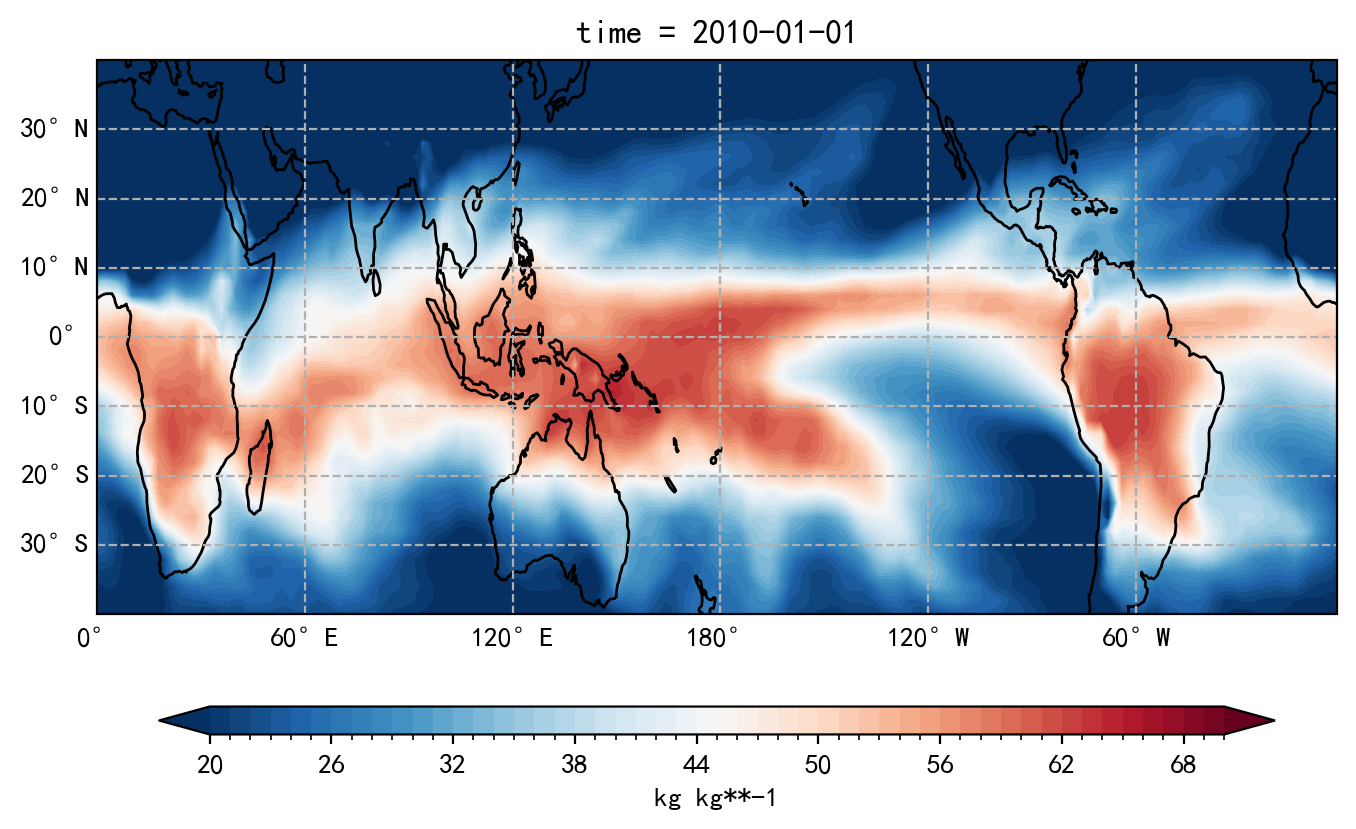

In [189]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(180)}, dpi=200,figsize=(8, 6))

contour = sph_trap[0].plot.contourf(ax=ax, levels=np.linspace(20,70,51), cmap='RdBu_r', extend='both', add_colorbar=False,
                                              transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linestyle='--')  # 添加经纬度网格并显示标签
gl.right_labels = False  # 关闭右侧标签
gl.top_labels = False    # 关闭顶部标签
ax.set_aspect(2)
# 添加横轴方向的colorbar
cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.1, shrink=0.9,aspect=40)
cbar.set_label('kg kg**-1')  

plt.show()

看看纬向平均的差异

In [190]:
sph_trap_numpy[0].shape

(41, 180)

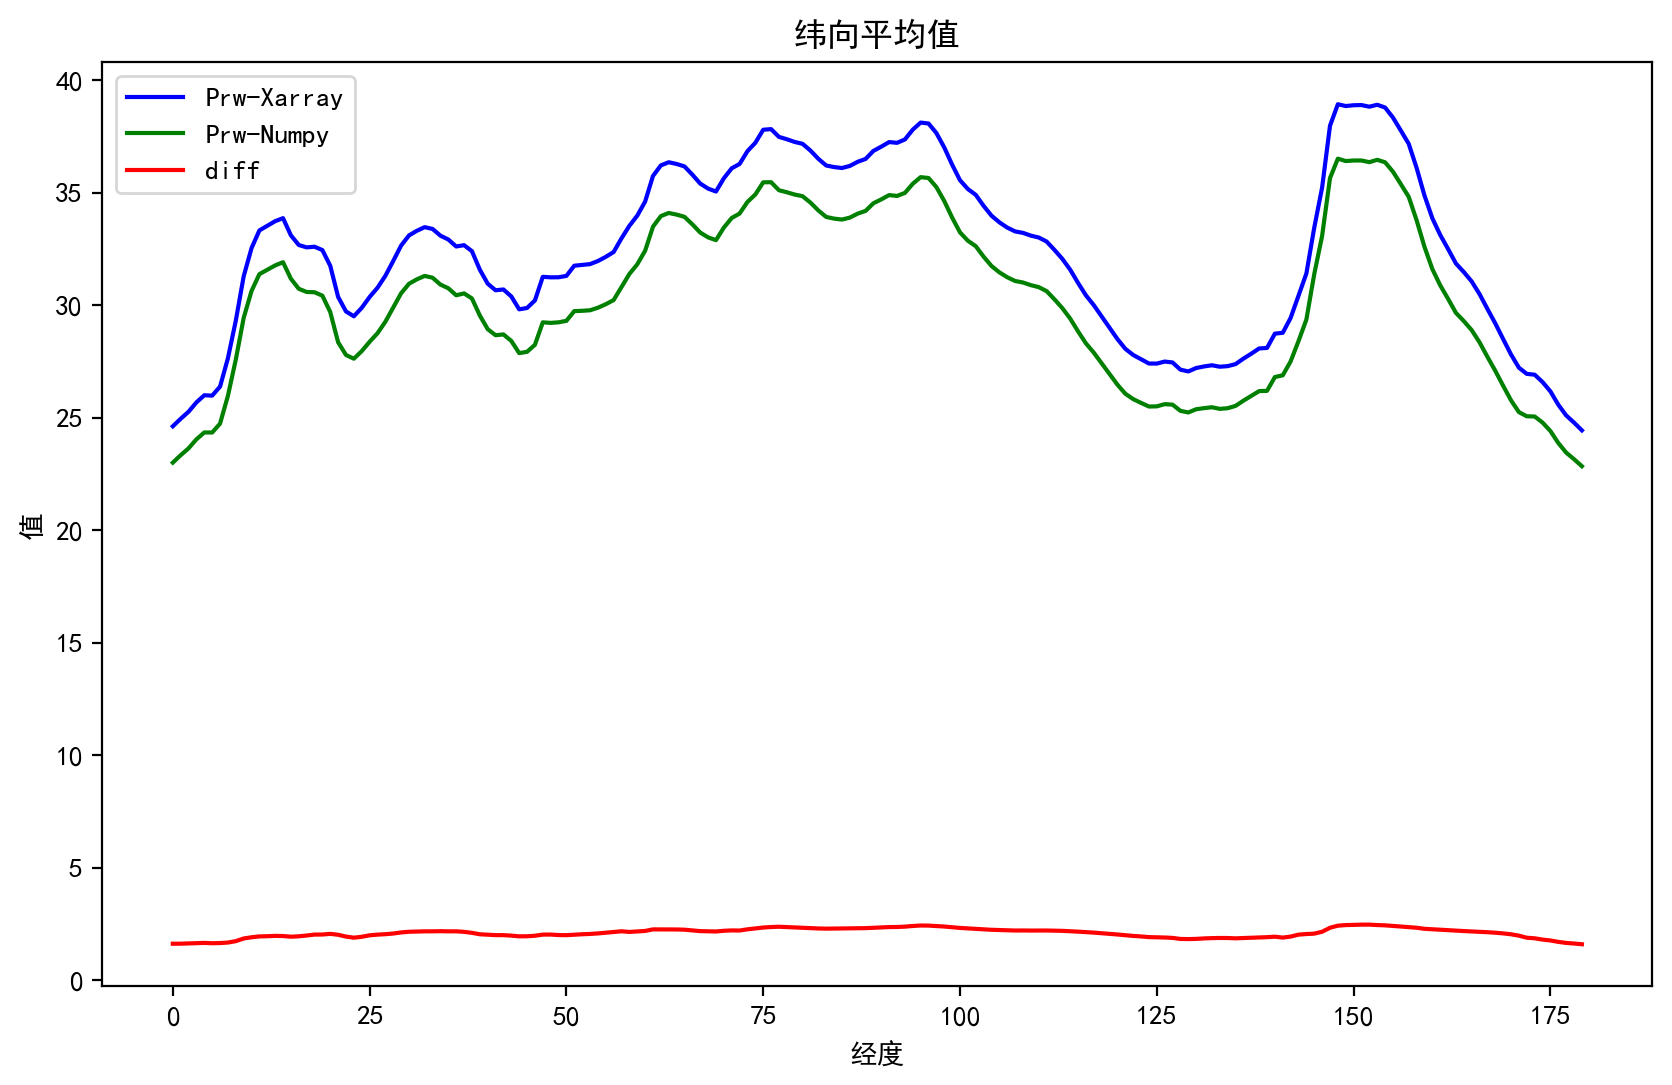

In [191]:
dataset = [sph_trap[0].mean('latitude'), np.nanmean(sph_trap_numpy[0],axis=0), sph_trap[0].mean('latitude')- np.nanmean(sph_trap_numpy[0],axis=0)]
data_title = ['Prw-Xarray', 'Prw-Numpy', 'diff']

colors = ['b', 'g', 'r']  

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))

# 绘制三个数据的纬向平均值在同一个图上
for i, data in enumerate(dataset):
    line = ax.plot(data, label=data_title[i], color=colors[i])

ax.set_title('纬向平均值')
ax.set_xlabel('经度')
ax.set_ylabel('值')
ax.legend()

plt.show()

找个cmip6的模式数据来对比一下

<xarray.DataArray 'prw' ()> Size: 4B
array(0.7178916, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2010-01-16T12:00:00 <xarray.DataArray 'prw' ()> Size: 4B
array(61.46656, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2010-01-16T12:00:00


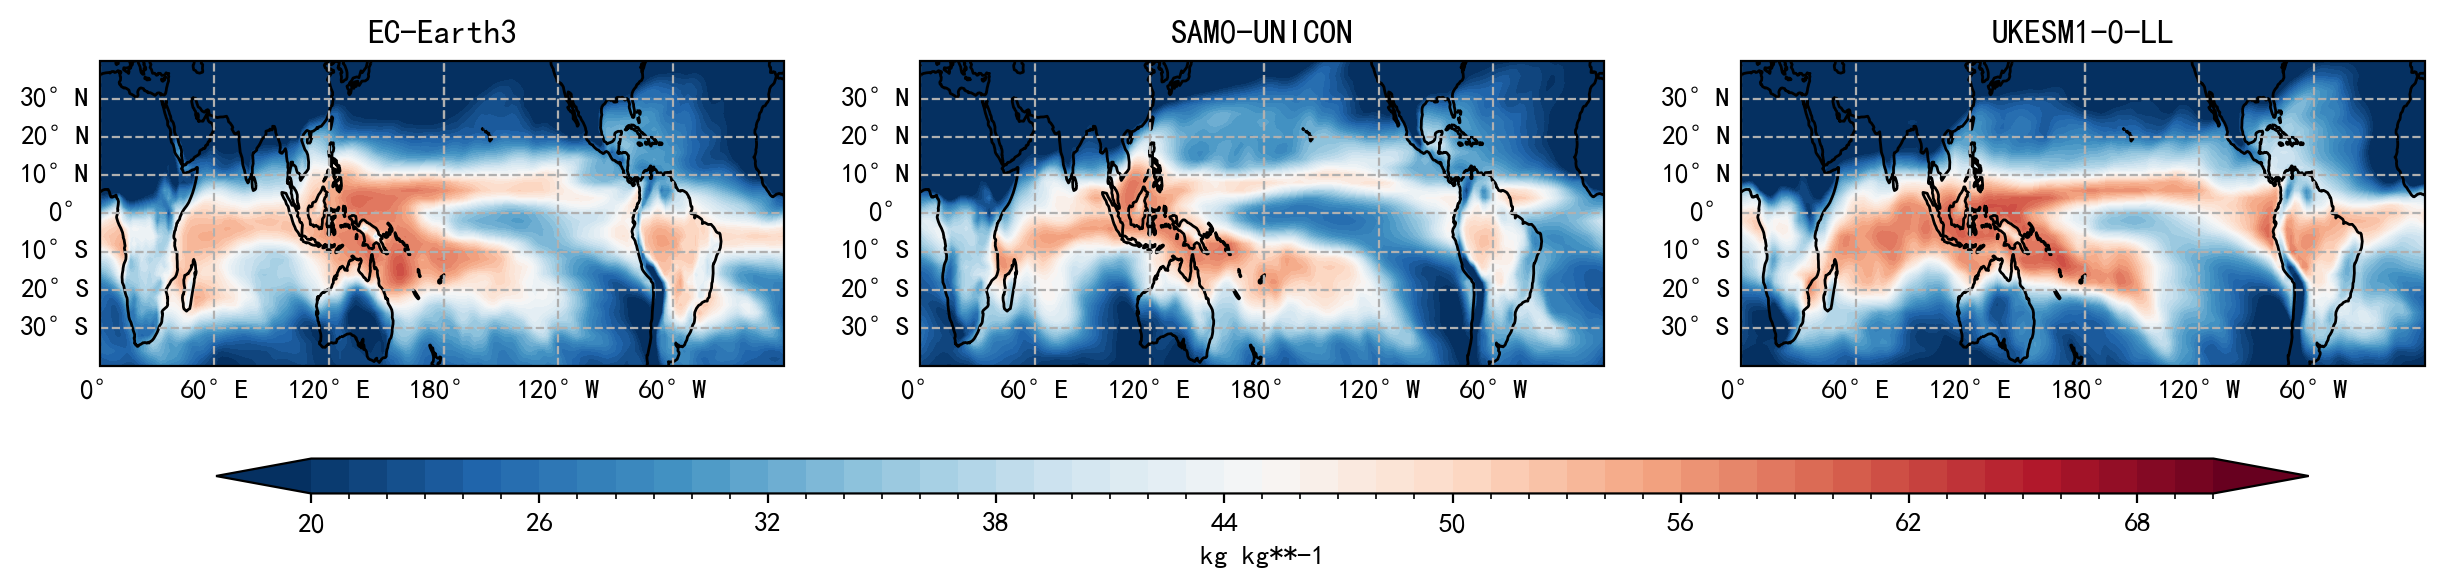

In [192]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

model_paths = [
    "I://EC-Earth3_historical_r1i1p1f1_1997-2014_interpolated.nc",
    "I://SAM0-UNICON_historical_r1i1p1f1_1997-2014_interpolated.nc",
    "I://UKESM1-0-LL_historical_r1i1p1f2_1997-2014_interpolated.nc",
]

model_names = ['EC-Earth3', 'SAM0-UNICON', 'UKESM1-0-LL']
# 读取所有模型数据
models = [xr.open_dataset(path).prw.sel(time='2010', lat=slice(-40, 40), lon=slice(0, 360))[0] for path in model_paths]
print(models[0].min(),models[0].max())

fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree(180)}, dpi=200, figsize=(15, 6))

for i, (model, ax) in enumerate(zip(models, axes)):

    model.plot.contourf(ax=ax, levels=np.linspace(20, 70, 51), cmap='RdBu_r', extend='both',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linestyle='--')  # 添加经纬度网格并显示标签
    gl.right_labels = False  # 关闭右侧标签
    gl.top_labels = False    # 关闭顶部标签
    ax.set_title(f'{model_names[i]}')
    ax.set_aspect(2)

cbar = fig.colorbar(contour, ax=axes, orientation='horizontal', pad=0.1, shrink=0.9, aspect=60)
cbar.set_label('kg kg**-1')

# plt.show()

##
读取ERA5的TCWV相同时间的数据来看看效果

In [193]:
era5_path = r'I://download.nc'
era5_tcwv = xr.open_dataset(era5_path).sortby('latitude').tcwv.sel(time='2010', 
            latitude=slice(-40, 42))
era5_tcwv_lon = convert_lon(era5_tcwv).interp(longitude=np.arange(0, 360, 2),latitude=np.arange(-40, 42, 2))
era5_tcwv_lon
print(era5_tcwv_lon.min(), era5_tcwv_lon.max())

<xarray.DataArray 'tcwv' ()> Size: 8B
array(0.77084657) <xarray.DataArray 'tcwv' ()> Size: 8B
array(62.84504249)


插值到相同的分辨率看看效果

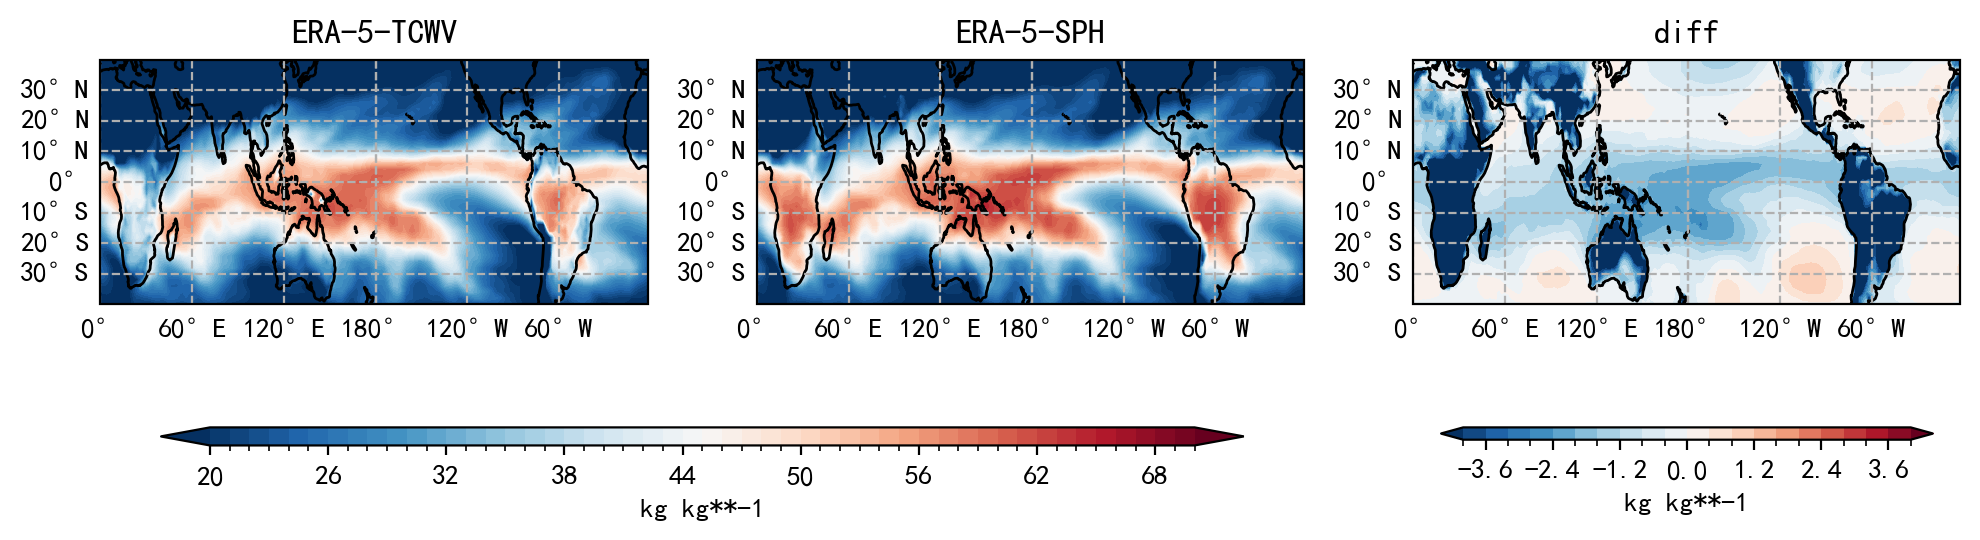

In [200]:
dataset = [era5_tcwv_lon[0], sph_trap[0], era5_tcwv_lon[0] - sph_trap[0]]
data_title = ['ERA-5-TCWV', 'ERA-5-SPH', 'diff']
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree(180)}, dpi=200, figsize=(12, 8))

# 绘制前两个子图并共用一个颜色条
for i, (data, ax) in enumerate(zip(dataset[:2], axes[:2])):
    contour = data.plot.contourf(ax=ax,
                                 levels=np.linspace(20, 70, 51),
                                 cmap='RdBu_r', extend='both', add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linestyle='--')  # 添加经纬度网格并显示标签
    gl.right_labels = False  
    gl.top_labels = False    
    ax.set_title(f'{data_title[i]}')
    ax.set_aspect(2)

cbar = fig.colorbar(contour, ax=axes[:2], orientation='horizontal', pad=0.1, shrink=0.9, aspect=60)
cbar.set_label('kg kg**-1')

contour_diff = dataset[2].plot.contourf(ax=axes[2],
                                        levels=np.linspace(-4, 4,21),
                                        cmap='RdBu_r', extend='both', add_colorbar=False, transform=ccrs.PlateCarree())
axes[2].coastlines()
gl = axes[2].gridlines(draw_labels=True, linestyle='--')  # 添加经纬度网格并显示标签
gl.right_labels = False  
gl.top_labels = False    
axes[2].set_title(f'{data_title[2]}')
axes[2].set_aspect(2)

cbar_diff = fig.colorbar(contour_diff, ax=axes[2], orientation='horizontal', pad=0.1, shrink=0.9, aspect=40)
cbar_diff.set_label('kg kg**-1')
plt.show()

看来TCWV应该是水汽积分得到的,差异还可以接受,在陆地上存在较大的负偏差

再从纬向平均上来看看差异

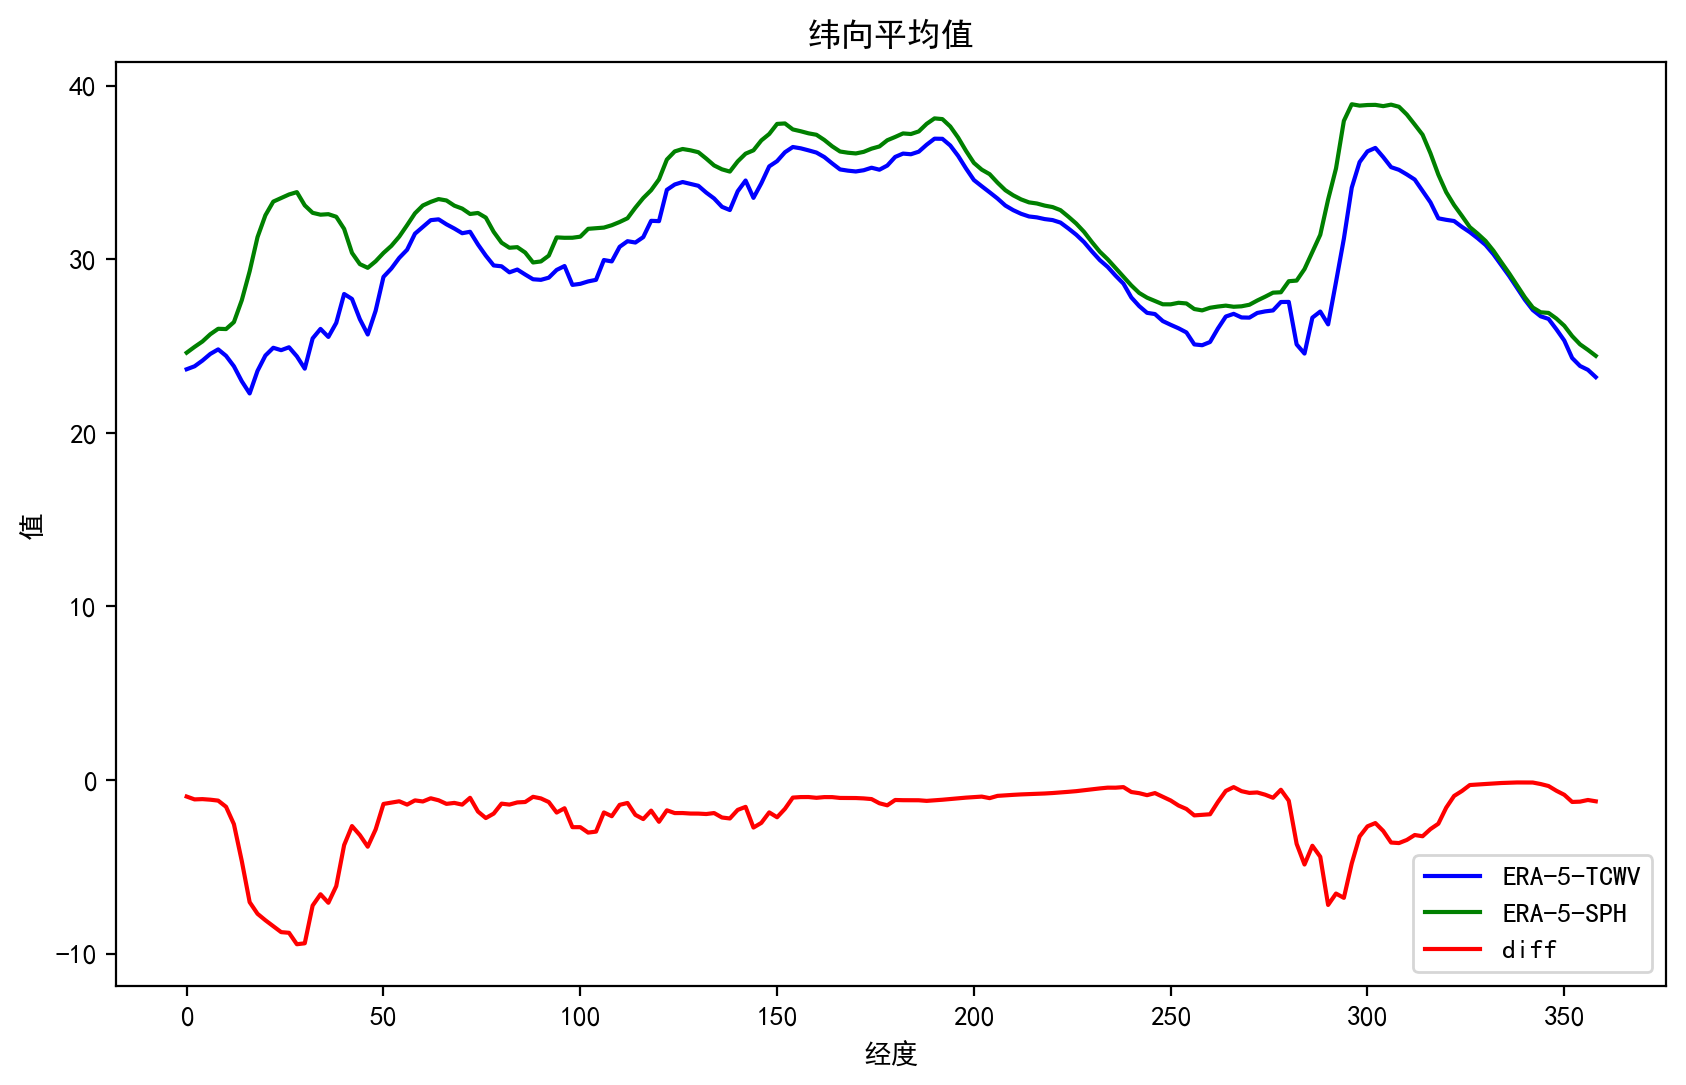

In [195]:
dataset = [era5_tcwv_lon[0], sph_trap[0], era5_tcwv_lon[0] - sph_trap[0]]
data_title = ['ERA-5-TCWV', 'ERA-5-SPH', 'diff']

colors = ['b', 'g', 'r']  

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))

# 绘制三个数据的纬向平均值在同一个图上
for i, data in enumerate(dataset):
    line = data.mean('latitude').plot(ax=ax, label=data_title[i], color=colors[i])

ax.set_title('纬向平均值')
ax.set_xlabel('经度')
ax.set_ylabel('值')
ax.legend()

plt.show()

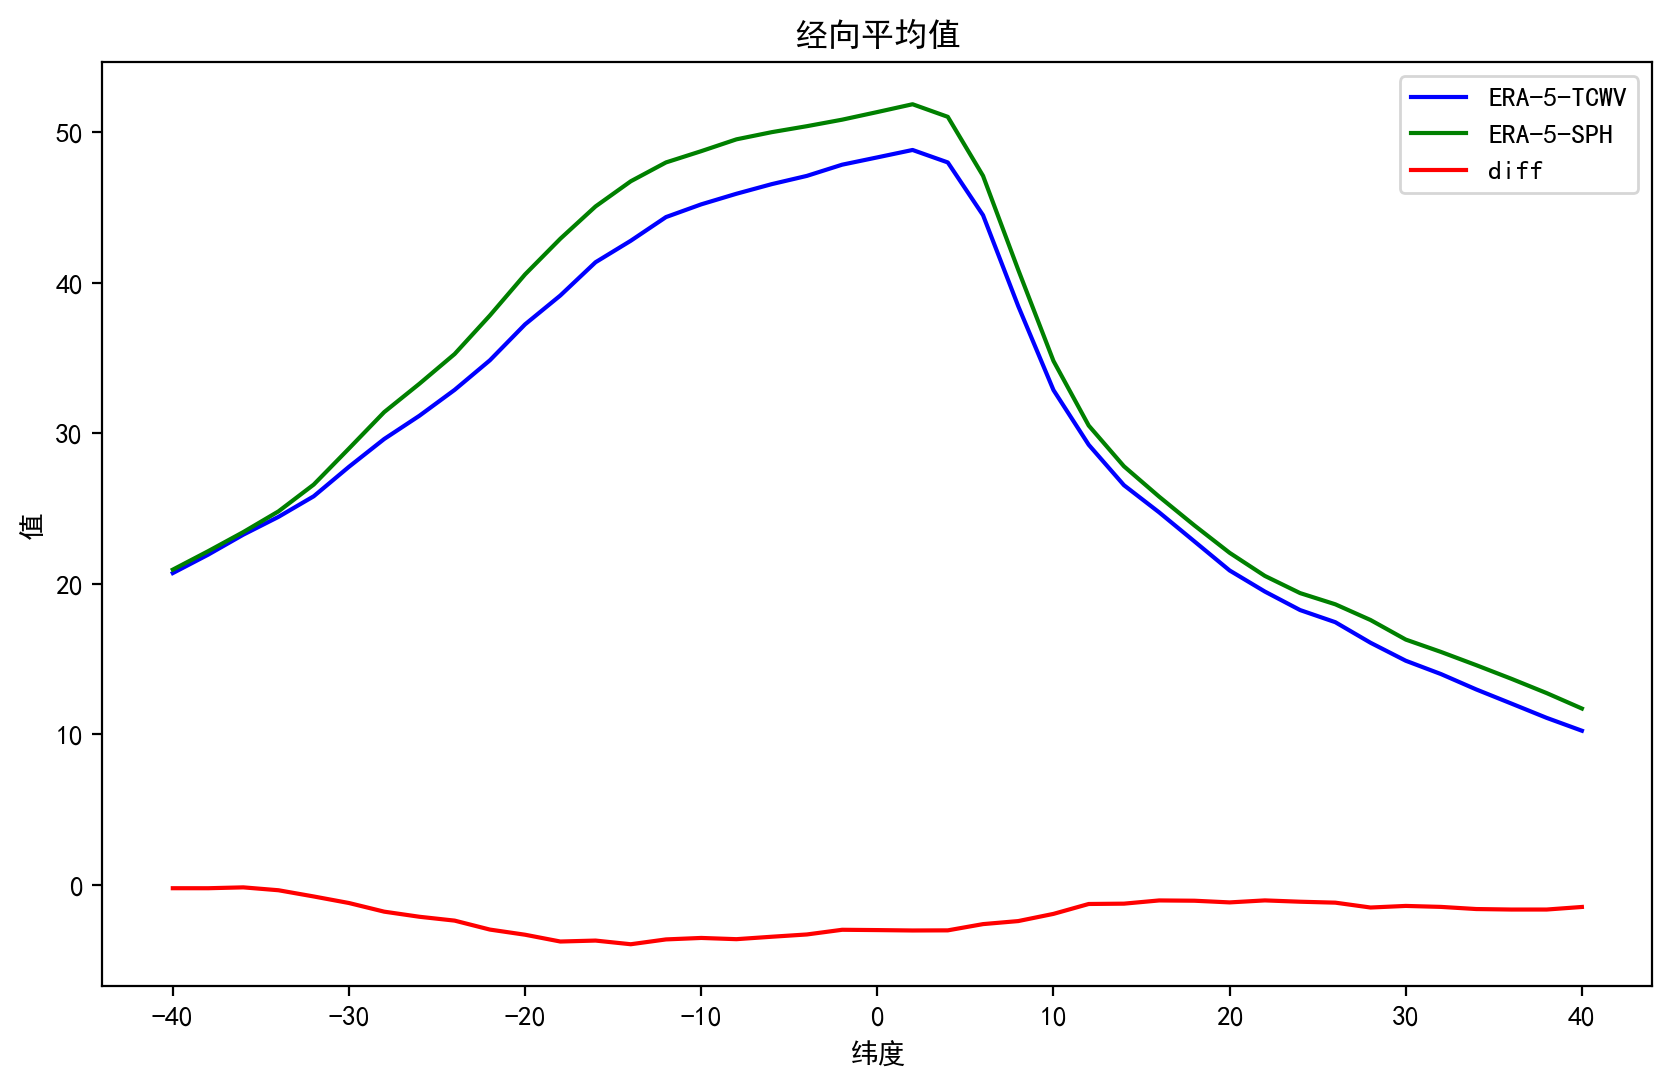

In [196]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))

# 绘制三个数据的纬向平均值在同一个图上
for i, data in enumerate(dataset):
    line = data.mean('longitude').plot(ax=ax, label=data_title[i], color=colors[i])

ax.set_title('经向平均值')
ax.set_xlabel('纬度')
ax.set_ylabel('值')
ax.legend()

plt.show()